# Semester 3 Coding Portfolio Topic 3 Summative:
# Linear Regression

In this notebook, you are asked to do original work with little guidance, based on the skills you learned in the formative part (as well as lectures and workshops).
This section is graded not just on passing automated tests, but also on quality, originality, and effort (see assessment criteria in the assignment description).

In [1]:
# TODO: Please enter your student number here
STUDENT_NUMBER = ...

# SUMMATIVE ASSESSMENT

For this summative assignment, we ask you to find a dataset from an internet source of choice. You will then analyze this dataset using linear regression and interpret the results.

The general assessment criteria for all summative assignments are mentioned in the assignment description on Canvas. Each notebook also has a few specific criteria we look for; make sure you fulfil them in your approach to this assignment.
In general, make sure this notebook represents a complete project: Write an explanation of what you are hoping to achieve with your analysis, document your code well, and present results in a comprehensive way.

## Assessment criteria specific to linear regression
 - Linear regression is properly implemented using a suitable dataset.
 - The R-squaredvalue was checked to determine how well the model explained the variance in thedependent variable.
 - Coefficients were examined to assess whether the predictors had a statistically significant relationship with the dependent variable.
 - The differences between observed and predicted values were analyzed to ensure they were randomly distributed.
 - Multicollinearity among predictors was checked using Correlation Matrices, and steps were taken to remove multicollinear variables where needed, to ensure proper convergence of the optimizer.
 - Correctly Splits the data into training, validation and test. If no Validation, provides sensible reasoning in the comments. 
 - Fits and compares a number of models (minimum 2) under the appropriate comparison metrics.
 - In their interpretation of the comparison students correctly interpret the direction and magnitude of the metrics.
 - Calculates the generalisation error of the model. Offers a distribution or an interval around the generalisation error.

Pick a dataset of your choice. Please ensure your dataset is a csv file under 100MB named sem3_topic3_linreg_summative_data.csv

In [2]:
# Do NOT modify the contents of this cell. Start your customization in the next one!
import pandas as pd

custom_data_path = "sem3_topic3_linreg_summative_data.csv"
custom_df = pd.read_csv(custom_data_path)

<table>
<tr>
<td style="vertical-align: top; padding-right: 20px;">

**BACKSTORY**


Amsterdam is a city of clubs and music, however I do not tend to frequent those establishments. Apart from me being a more of a jazz and not techno person, I prefer relaxed dancing to the music (the appeal of a club packed with people makes me think of sardines in a can). 


I also did professional ballroom dancing for 11 years, so even if I don't like clubs and techno I LOVE to dance. I have been using spotify for YEARS to listen to my favourite tunes (hashtag ILOVE🇸🇪), so when I came across a Kaggle dataset on spotify songs - I loved the idea of considering this dataset for the assignment.


So in this notebook I will be **(1) predicting popularity from the danceability**, and similarly **(2) predicting popularity from a set of other variables**. 

PS: **this is me in the photo!**  


Another PS: if anyone is worried about ethical consideration - I have **consent** from my dance partner to display the image!!

</td>

<td>
<img src="./cool-dance.png" width="750">
</td>
</tr>
</table>


**IMPORTS**

In [3]:
#data handling
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

#statistics
from scipy import stats #CHECK NOT USAGE

**(0) LOAD AND EXPLORE DATA**

In [27]:
df = pd.read_csv("sem3_topic3_linreg_summative_data.csv")
print(f"Successfully loaded data: {df.shape[0]} rows, {df.shape[1]} columns.")

print(df.isna().sum())

print(df['popularity'].unique())

Successfully loaded data: 114000 rows, 21 columns.
Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64
[ 73  55  57  71  82  58  74  80  56  69  52  62  54  68  67  75  63  70
   0   1  46  61  60  51  66  64  65  44  45  50  59  49  53  47  43  42
  20  22  35  19  24  18  23  40  38  41  30  37  39  48  36  34  26  32
  33  21  31  28  29  27  25  16   3  12   7  10   9  11  17   8  15  87
  83  86  93  76  78   4   2   5  85  81  84  72  79  77   6  13  14  89
  96 100  98  88  92  90  91  99  97  95  94]


In [5]:
def describe_df(df):
    column_names = df.columns.tolist()
    print("\nColumn names:", column_names)

    first_rows = df.head()
    print("\nFirst five rows:")
    print(first_rows)

    data_types = df.dtypes
    print("\nData types for each column:")
    print(data_types)

    missing_counts = df.isnull().sum()
    print("\nMissing values in each column:")
    print(missing_counts)

describe_df(df)



Column names: ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']

First five rows:
   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                   

**(1) DATA CLEANING**

(1.1) Handle column types:

Upon inspection discovered that not all data types are handeled correctly. So add a function that normalises all columns to the correct value (aka: if column supposed to be binary but there is a random number, assign NaN to such value).


In [6]:
expected_types = {
    "Unnamed: 0": "int64",
    "track_id": "object",
    "artists": "object",
    "album_name": "object",
    "track_name": "object",
    "popularity": "int64",
    "duration_ms": "int64",
    "explicit": "bool",
    "danceability": "float64",
    "energy": "float64",
    "key": "int64",
    "loudness": "float64",
    "mode": "int64",
    "speechiness": "float64",
    "acousticness": "float64",
    "instrumentalness": "float64",
    "liveness": "float64",
    "valence": "float64",
    "tempo": "float64",
    "time_signature": "int64",
    "track_genre": "object",
}

def clean_column_types(df):
    for column, expected in expected_types.items():

        if expected in ("int64", "float64"):
            df[column] = pd.to_numeric(df[column], errors="coerce")
            #tries to parse each value to a number -> invalid parsing as NaN
        elif expected == "bool":
            values = df[column].astype(str).str.strip().str.lower()
            #handle messy case variations to one format so we can map them
            df[column] = values.map({"true": True, "false": False})
            #.map to boolean values, invalid parsing as NaN
        else:  # object/text
            df[column] = df[column].astype(str)
            #plain string conversion

    return df

clean_column_types(df)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,...,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,...,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,...,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


(1.2) Remove rows with missing values - **DROP**


To ensure future corecctness remove any rows with NaN values and not consider that data.

In [7]:
df = clean_column_types(df)

print("Missing values per column after coercion:")
print(df.isna().sum())

df = df.dropna().reset_index(drop=True)
print(f"Rows after dropping NaNs: {len(df)}")


Missing values per column after coercion:
Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64
Rows after dropping NaNs: 114000


(1.3) Remove duplicate tracks

To ensure that there are no repetitions remove the duplicate tracks from dataset and only keep the first occurance of each track. Print shape list to ensure that duplicates were removed.

In [8]:
num_duplicates = df.duplicated(subset=["track_id"]).sum()
print(f"Removed {num_duplicates} duplicate tracks")

df = df.drop_duplicates(subset=["track_id"], keep="first").reset_index(drop=True)

print("Shape after removing duplicate tracks:", df.shape)

Removed 24259 duplicate tracks
Shape after removing duplicate tracks: (89741, 21)


(1.4) **BASIC STATS & INTERPRITATION**



In [9]:
stats = df.describe()
print(stats)



          Unnamed: 0    popularity   duration_ms  danceability        energy  \
count   89741.000000  89741.000000  8.974100e+04  89741.000000  89741.000000   
mean    53479.144148     33.198438  2.291418e+05      0.562166      0.634458   
std     33409.981502     20.580824  1.129477e+05      0.176691      0.256605   
min         0.000000      0.000000  0.000000e+00      0.000000      0.000000   
25%     23767.000000     19.000000  1.730400e+05      0.450000      0.457000   
50%     50681.000000     33.000000  2.132930e+05      0.576000      0.676000   
75%     80618.000000     49.000000  2.642930e+05      0.692000      0.853000   
max    113999.000000    100.000000  5.237295e+06      0.985000      1.000000   

                key      loudness          mode   speechiness  acousticness  \
count  89741.000000  89741.000000  89741.000000  89741.000000  89741.000000   
mean       5.283549     -8.499004      0.636966      0.087442      0.328289   
std        3.559897      5.221490      0.4

**BASIC STATS: OBSERVATIONS**


(A) duration_ms - extreme outliers 


(B) zero/near zero values 


(C) time_signature - zero value cannot exist

In [10]:
df_clean = df[
    (df['popularity'] > 0) &  # - zero-popularity (invalid)
    (df['duration_ms'] <= 600000) &  # - extreme duration outliers
    (df['time_signature'] > 0)  # - invalid time signatures
].copy()

print(f"Rows before: {len(df)}, after: {len(df_clean)}")

Rows before: 89741, after: 79648


**BASIC STATS CONCLUSIONG on df_clean**


1. Row count dropped


2. popularity starts at 1: mean rose from <value> to <value> + tighter std (since no zero pop tracks)


3. duration_ms: mean fell from <value> to <value> (since less extreme songs)


4. the rest seems the same

(1.5) Finalising the data cleaning

In [12]:
#keep only numeric predicts
keep_columns = [
    'popularity', 'danceability', 'energy', 'loudness', 
    'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo'
    
]

df_final = df_clean[keep_columns]

**(2) MULTICOLLINEARITY CHECK**

**CONCEPT**


Multicollinearity happens when two/more predictor variables are highly correlated with each other


 -> saying similar things about your data.


EG: if base prediction on
    
    
    Energy (how intense the song is)
    
    
    Loudness (how loud the song is)
Intense songs tend to be loud (vice-versa) -> remove !

**STRATEGY** 


1) Identify highly correlated pairs


2) Keep predictor correlating more with **dancibility** 


3) Drop the other one

(2.1) Calculate & visualise correlation matrix

In [14]:
corr_matrix = df_final.corr()
print("\nFull Correlation Matrix:")
print(corr_matrix)


Full Correlation Matrix:
                  popularity  danceability    energy  loudness  speechiness  \
popularity          1.000000      0.075158 -0.035523  0.071285    -0.085090   
danceability        0.075158      1.000000  0.095988  0.228332     0.101912   
energy             -0.035523      0.095988  1.000000  0.756688     0.134240   
loudness            0.071285      0.228332  0.756688  1.000000     0.047477   
speechiness        -0.085090      0.101912  0.134240  0.047477     1.000000   
acousticness       -0.006699     -0.139810 -0.725962 -0.573820     0.017974   
instrumentalness   -0.192152     -0.168390 -0.175122 -0.428563    -0.102723   
liveness           -0.050696     -0.134208  0.194850  0.084464     0.231868   
valence            -0.004062      0.473630  0.234342  0.264178     0.028859   
tempo              -0.020187     -0.055295  0.243584  0.213737    -0.011612   

                  acousticness  instrumentalness  liveness   valence     tempo  
popularity           -0

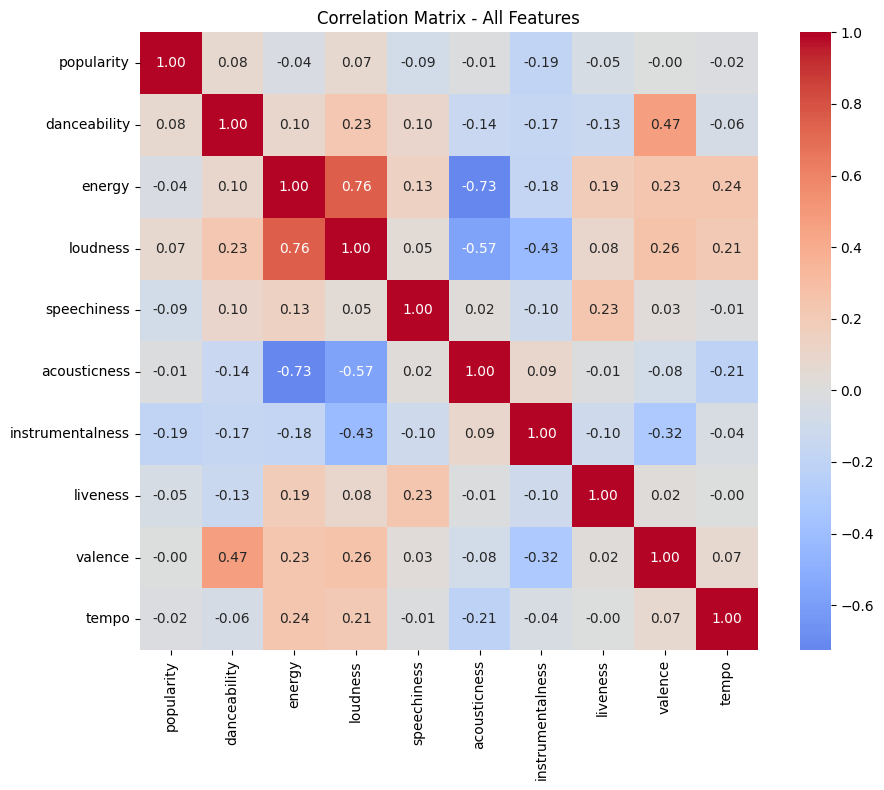

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True)
plt.title('Correlation Matrix - All Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

Table below summarizes the variable descriptions relevant for the corr matrix interpritation. 


! NB: the format of the table below was generated using Claude AI !

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>popularity</b></td>
      <td>Spotify popularity score for the track (0–100), based on streaming and recent engagement.</td>
    </tr>
    <tr>
      <td><b>danceability</b></td>
      <td>How suitable the track is for dancing, based on tempo, rhythm stability, and beat strength (0–1).</td>
    </tr>
    <tr>
      <td><b>energy</b></td>
      <td>Intensity and liveliness of the track (0–1).</td>
    </tr>
    <tr>
      <td><b>loudness</b></td>
      <td>Average loudness of the track in decibels (dB). Typically negative values.</td>
    </tr>
    <tr>
      <td><b>speechiness</b></td>
      <td>Detects presence of spoken words—higher values indicate more speech-like content (0–1).</td>
    </tr>
    <tr>
      <td><b>acousticness</b></td>
      <td>Confidence measure of whether the track is acoustic (0–1).</td>
    </tr>
    <tr>
      <td><b>instrumentalness</b></td>
      <td>Predicts if a track contains no vocals—values close to 1 indicate instrumental tracks.</td>
    </tr>
    <tr>
      <td><b>liveness</b></td>
      <td>Likelihood the recording is live (0–1).</td>
    </tr>
    <tr>
      <td><b>valence</b></td>
      <td>Musical positiveness—higher values indicate happier-sounding tracks (0–1).</td>
    </tr>
    <tr>
      <td><b>tempo</b></td>
      <td>Beats per minute (BPM) of the song.</td>
    </tr>
    <tr>
      <td><b>duration_ms</b></td>
      <td>Track duration in milliseconds.</td>
    </tr>
    <tr>
      <td><b>explicit</b></td>
      <td>Boolean indicating whether the song contains explicit content (True/False).</td>
    </tr>
    <tr>
      <td><b>mode</b></td>
      <td>Indicates major (1) or minor (0) musical key.</td>
    </tr>
    <tr>
      <td><b>time_signature</b></td>
      <td>Beats per bar, usually 3 or 4 in modern music.</td>
    </tr>
    <tr>
      <td><b>track_id</b></td>
      <td>Spotify’s unique identifier for the track.</td>
    </tr>
    <tr>
      <td><b>track_name</b></td>
      <td>Name/title of the song.</td>
    </tr>
    <tr>
      <td><b>album_name</b></td>
      <td>Name of the album where the track appears.</td>
    </tr>
    <tr>
      <td><b>artists</b></td>
      <td>Artist(s) who performed the track.</td>
    </tr>
    <tr>
      <td><b>track_genre</b></td>
      <td>The primary genre label associated with the track.</td>
    </tr>
  </tbody>
</table>


**corr matrix analysis**


1. **popularity** weak lin relationship w all ausio features -> corrs fall bw <value> & <value>, 


hence no single feature predicts popularity on its own.


2. **energy** & **loudness** strong + corr  -> louder songs more energetic
3. **energy** & **acousticness** strong - corr -> energetic songs not/barely acoustic
4. **loudness** & **acousticness**  similarly - corr
5. **valence** & **danceability** moderate + corr -> happiers tunes more danceable


These patterns suggest that the dataset contains **non-linear interactions** among features. Since popularity is not strongly linearly related to any individual variable, this supports using a **more flexible model (i pick random forest)** alongside linear regression to capture non-linear relationships and interactions.


(2.2) Identify & remove highly correlated features


Acctoually in the previous step I visually look and analyse however for universality of the pipelina added the manual identification 

In [16]:
print("\nHighly correlated feature pairs (absolute correlation > 0.85):")
high_corr_pairs = []

columns = list(corr_matrix.columns)
num_cols = len(columns)

for first_index in range(num_cols):
    first_column = columns[first_index]

    for second_index in range(first_index + 1, num_cols):
        second_column = columns[second_index]
        correlation_value = corr_matrix.iloc[first_index, second_index]

        if abs(correlation_value) > 0.85:
            high_corr_pairs.append((first_column, second_column, correlation_value))
            print(f"  {first_column} and {second_column}: {correlation_value:.3f}")



Highly correlated feature pairs (absolute correlation > 0.85):


We care about both strong positive (close to +1) and strong negative (close to -1).
Taking abs(...) converts negative correlations to positive numbers so we can compare
magnitudes only. If that magnitude is greater than 0.85, we treat the pair as highly
correlated and report it.

Pearson correlation ranges from –1 to +1. A value of +0.9 means the two features move together strongly; –0.9 means they move in opposite directions but still with a strong linear relationship. By using abs(correlation_value), we convert both +0.9 and –0.9 to 0.9, letting us treat both as “high-magnitude” correlations. The > 0.85 threshold is arbitrary but common—you can tweak it to be stricter or looser depending on how aggressively you want to flag multicollinearity.

**CONCLUSION** for correlation matrix

**NO** highly correlated features were identifyed, however based on corr matrix other variables exhibit strong correlations, therefore **random forest model** as second pick



- It can automatically capture **non-linear relationships** between features and popularity.


- It naturally models **interactions** between strongly correlated variables.


- It makes fewer assumptions about the data (no linearity, normality, or homoscedasticity required).


- It is more robust to noise and multicollinearity.


- It often provides lower generalisation error compared to linear models when relationships are complex.





**(3) DATA PREP FOR MODELLING**


dropping redundant (categorical) columns

In [17]:
df_final = df.drop(columns=[
    "Unnamed: 0", 
    "track_id", 
    "track_name", 
    "album_name", 
    "artists"
])

X = df_final.drop(columns=["popularity"])
y = df_final["popularity"]


(4) **SPLIT INTO TRAIN, VALIDATION & TEST**


training majority of dataset that is fed into model/models 60%
validation compare models ->
testing 

In [18]:
#70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print("Train:", X_train.shape)
print("Validation:", X_valid.shape)
print("Test:", X_test.shape)

Train: (62818, 15)
Validation: (13461, 15)
Test: (13462, 15)


(5) **CATEGORICAL VS CONTINOUS**

track_genre -> categorical


explicit -> boolean (binary)


etc

In [19]:
#ident categorical and numeric columns
cat_cols = ["track_genre"]
num_cols = [col for col in X.columns if col not in cat_cols]

#OneHotEncode the genre
#its a transformer class created and used within pipilens
#for me it transforms the track_genre column into multiple binary columns so the model can use them
#pass numeric columns through unchanged
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

(6) **LIN REG**

In [20]:
linreg = Pipeline([
    ("prep", preprocess),            # preprocessing from Step 2
    ("model", LinearRegression())    # the linear regression model
])

#fitting the model on TRAINING data
linreg.fit(X_train, y_train)

#predict on VALIDATION data
pred_lr = linreg.predict(X_valid)


mae_lr = mean_absolute_error(y_valid, pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_valid, pred_lr))
r2_lr = r2_score(y_valid, pred_lr)

print("Linear Regression Performance (Validation Set)")
print("MAE:  ", mae_lr)
print("RMSE: ", rmse_lr)
print("R²:   ", r2_lr)

Linear Regression Performance (Validation Set)
MAE:   17.18777827244998
RMSE:  20.44926246662503
R²:    0.006077138244513058


In [21]:
#view lin reg coefficients
linreg_coefs = linreg.named_steps["model"].coef_
feature_names = linreg.named_steps["prep"].get_feature_names_out()

coef_table = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": linreg_coefs
})

coef_table.sort_values(by="Coefficient", ascending=False).head(15)


,Feature,Coefficient
118,num__loudness,0.294511
126,num__time_signature,0.013951
114,num__explicit,0.012699
117,num__key,0.011227
65,cat__track_genre_k-pop,0.011165
81,cat__track_genre_pop-film,0.009374
15,cat__track_genre_chill,0.009088
115,num__danceability,0.009024
5,cat__track_genre_anime,0.007340
44,cat__track_genre_grunge,0.006824


**LIN REG COEFFICIENTS ANALYSIS**

The coefficients show how each feature affects the predicted popularity score:


+ coefficients -> increasing the feature increases the predicted popularity


- coefficients -> opposite. 


**MAGNITUDE** individ coef strenghts = strenght of relationship


 This examination helps confirm that some predictors have weak linear effects, which is consistent with the low R² value of the linear regression model.


(7) **RANDOM FOREST**

In [22]:
rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        n_jobs=-1, #thats the CPU cores to use
        random_state=42
    ))
])

#fitting the model on TRAINING data
rf.fit(X_train, y_train)

#predict on VALIDATION set
pred_rf = rf.predict(X_valid)

#metrics
mae_rf = mean_absolute_error(y_valid, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_valid, pred_rf))
r2_rf = r2_score(y_valid, pred_rf)

print("Random Forest Performance (Validation Set)")
print("MAE:  ", mae_rf)
print("RMSE: ", rmse_rf)
print("R²:   ", r2_rf)

Random Forest Performance (Validation Set)
MAE:   13.89236425471568
RMSE:  17.86858951351151
R²:    0.24111157967867636


In [23]:
"""
rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42
    ))
])

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_valid)

mae_rf = mean_absolute_error(y_valid, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_valid, pred_rf))
r2_rf = r2_score(y_valid, pred_rf)

print("Random Forest Performance (Validation Set)")
print("MAE:  ", mae_rf)
print("RMSE: ", rmse_rf)
print("R²:   ", r2_rf)
"""


'\nrf = Pipeline([\n    ("prep", preprocess),\n    ("model", RandomForestRegressor(\n        n_estimators=200,\n        random_state=42\n    ))\n])\n\nrf.fit(X_train, y_train)\npred_rf = rf.predict(X_valid)\n\nmae_rf = mean_absolute_error(y_valid, pred_rf)\nrmse_rf = np.sqrt(mean_squared_error(y_valid, pred_rf))\nr2_rf = r2_score(y_valid, pred_rf)\n\nprint("Random Forest Performance (Validation Set)")\nprint("MAE:  ", mae_rf)\nprint("RMSE: ", rmse_rf)\nprint("R²:   ", r2_rf)\n'

(8) **MODEL COMPARISON**


to compare the metrics -> put into a table for visual inspection

In [24]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE":  [mae_lr, mae_rf],
    "RMSE": [rmse_lr, rmse_rf],
    "R²":   [r2_lr, r2_rf]
})

print(results)


               Model        MAE       RMSE        R²
0  Linear Regression  17.187778  20.449262  0.006077
1      Random Forest  13.892364  17.868590  0.241112


### Model Interpretation

The comparison between Linear Regression and Random Forest shows a clear performance difference across all evaluation metrics.


### Metric Definitions (Quick & Simple)

**MAE — Mean Absolute Error**  
- Average size of errors  
- Uses absolute differences  
- Lower = better (smaller mistakes)

**RMSE — Root Mean Squared Error**  
- Square-root of average squared errors  
- Punishes large errors more  
- Lower = better (more stable)

**R² — Coefficient of Determination**  


**r^2 tells how much our model explain variance=std in the data**
- Measures variance explained  
- 0 = explains nothing  
- 1 = perfect explanation  
- Higher = better fit

**1. Prediction Error (MAE & RMSE)**  
The Random Forest model produces notably smaller errors, with a lower MAE (13.89 vs. 17.19) and RMSE (17.87 vs. 20.45).  
Lower values in these metrics indicate that Random Forest makes more accurate predictions and is less affected by large deviations.

**2. Explained Variance (R²)**  
Random Forest achieves an R² value of **0.241**, meaning it explains approximately **24%** of the variation in song popularity.  
In contrast, Linear Regression achieves an R² value close to **0**, indicating that it explains almost none of the variance.  
This demonstrates that popularity is not well captured by a simple linear relationship.

**3. Overall Conclusion**  
The consistent improvements across MAE, RMSE, and R² indicate that Random Forest captures more complex, non-linear patterns in the audio features.  
Therefore, **Random Forest is the superior model** and is selected as the final model for further evaluation.


(9) **FINAL MODEL EVALUATION**

In [25]:
#choose the better model (Random Forest)
final_model = rf  

#predict on the test set
test_pred = final_model.predict(X_test)

#compute metrics on the test set
mae_test = mean_absolute_error(y_test, test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, test_pred))
r2_test = r2_score(y_test, test_pred)

print("Final Model Evaluation (Test Set)")
print("MAE:  ", mae_test)
print("RMSE: ", rmse_test)
print("R²:   ", r2_test)

Final Model Evaluation (Test Set)
MAE:   13.937416395605839
RMSE:  18.02841768161745
R²:    0.2276372167213333


**test set performance evaluation**

- The final Random Forest model was evaluated on the **unseen test set**.  


- The resulting **MAE, RMSE, and R²** provide an unbiased estimate of performance. 


- These metrics show how well the model **generalises** beyond the training and validation data.


**test set interpretation**

- **MAE (13.94):** The model’s predictions are, on average, about 14 popularity points away from the true values. This indicates moderate error given the 0–100 popularity scale.

- **RMSE (18.03):** The model occasionally makes larger mistakes, which is expected for human-preference data. RMSE shows a similar error level to MAE but emphasizes big errors more.

- **R² (0.228):** The model explains roughly 23% of the variation in popularity. This is reasonable for music datasets, as popularity is heavily influenced by external factors not captured in audio features.

- **Overall:** The Random Forest generalises fairly well to unseen data and performs consistently with its validation results. While not highly accurate, it captures some meaningful patterns in the data.


(10) **GENERALISATION ERROR**


bootystrapping resamples the test data with replacements many times and measures the error each time


hence distribution of rmse distribution


hence can calc confidence interval

**bootstrapped generalisation error interpretation**

- The **mean bootstrapped RMSE is 18.03**, which is almost identical to the RMSE from the original test set.  
  ➝ This shows the model’s performance is consistent and not dependent on a lucky test split.

- The **95% confidence interval is [17.81, 18.25]**.  
  ➝ This interval is very narrow, meaning the model’s error does not vary much across different resampled test sets.

- The fact that the entire interval is close to **18** suggests that the model’s typical prediction error is stable and predictable.

- Overall, the Random Forest model shows **reliable generalisation**: performance on unseen data is unlikely to deviate far from the test RMSE.


**WHAT CAN BE BETTER**


1. dataset limited & music very personal


2. trying more advanced models like


Gradient Boosting Machines (XGBoost, LightGBM, CatBoost)

Neural networks

Support Vector Regression


3. improve hyperparameter tuning


n_estimators

max_depth

min_samples_split

min_samples_leaf

max_features

4. feature engineering = enhance dataset by creating new features


Energy * Danceability interaction

Genres grouped into broader categories

Normalised tempo

Acousticness bins (low/medium/high)


5. reduce noise & outliers 


Outliers (very famous artists)

Noisy tracks

Data imbalance


6. use cross validation instead of one split